
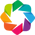

In [1]:
import holoviews as hv
hv.notebook_extension('bokeh')

In [2]:
import dask
import dask.dataframe as dd
import pandas as pd
from distributed import Client
client = Client(scheduler_file='/scratch/tmorton/dask/scheduler.json')

In [3]:
import glob
import sys
sys.path.append('..')
from explorer.catalog import ParquetCatalog, MatchedCatalog

def get_files(rerun, filt, tracts, unforced=False):
    table = 'unforced' if unforced else 'forced'
    return ['{}/plots/{}/tract-{}/{}.parq'.format(rerun, filt, t, table) for t in tracts]

filt = 'HSC-Z'
rerun = '/scratch/tmorton/hscRerun/DM-10859'

cosmos_files = get_files(rerun, filt, tracts=[9813])
cosmos_files_unforced = get_files(rerun, filt, tracts=[9813], unforced=True)
wide_files = get_files(rerun, filt, tracts=[8766, 8767])
wide_files_unforced = get_files(rerun, filt, tracts=[8766, 8767], unforced=True)

cosmos = ParquetCatalog(cosmos_files, client=client)
cosmos_unforced = ParquetCatalog(cosmos_files_unforced, client=client)
wide = ParquetCatalog(wide_files, client=client)
wide_unforced = ParquetCatalog(wide_files_unforced, client=client)

In [4]:
import numpy as np
import fastparquet

def perturb_coords(df, scatter=0.01):
    new_df = df.copy()
    new_df.index = new_df.index.astype(int)*10
    
    n = len(new_df)
    r = np.random.randn(n)*scatter * 1./3600 * np.pi / 180
    pa = np.random.random(n)*2*np.pi
    dra = r*np.cos(pa)
    ddec = r*np.sin(pa)
    
    new_df.coord_ra += dra
    new_df.coord_dec += ddec
    return new_df

def write_test_cats():
    wide1 = ParquetCatalog([wide_files[0]])
    wide2 = ParquetCatalog([wide_files[1]])
    df1 = wide1.df_all.sample(0.01).compute()
    df2 = wide2.df_all.sample(0.01).compute()    
    fastparquet.write('test_data/8766/forced.parq', df1)
    fastparquet.write('test_data/8767/forced.parq', df2)
    xdf1 = perturb_coords(df1)
    xdf2 = perturb_coords(df2)
    fastparquet.write('test_data/8766_perturb/forced.parq', xdf1)
    fastparquet.write('test_data/8767_perturb/forced.parq', xdf2)    

In [5]:
# write_test_cats()

In [6]:
from explorer.catalog import MatchedCatalog
files1 = ['test_data/8766/forced.parq', 'test_data/8767/forced.parq']
files2 = ['test_data/8766_perturb/forced.parq', 'test_data/8767_perturb/forced.parq']

cat1 = ParquetCatalog(files1)
cat2 = ParquetCatalog(files2)

matched = MatchedCatalog(cat1, cat2)

In [7]:
from explorer.functors import (Mag, MagDiff, CustomFunctor, DeconvolvedMoments, Column,
                            SdssTraceSize, PsfSdssTraceSizeDiff, HsmTraceSize,
                            PsfHsmTraceSizeDiff, CompositeFunctor)

funcs = [Mag('base_PsfFlux'), MagDiff('modelfit_CModel', 'base_PsfFlux')]
f = CompositeFunctor({k:fn for k,fn in zip(['x', 'y'], funcs)})

In [8]:
from explorer.catalog import MatchedCatalog
cosmos_matched = MatchedCatalog(cosmos, cosmos_unforced)
wide_matched = MatchedCatalog(wide, wide_unforced)

In [9]:
%time wide_matched._match_cats()

1671378 good matches, 50466 bad.
CPU times: user 9.44 s, sys: 664 ms, total: 10.1 s
Wall time: 12.3 s


In [10]:
from explorer.dataset import QADataset

matched_data = QADataset(wide_matched, funcs[0])

In [11]:
matched_data.df.head()

dec   label         ra          x        y0  \
id                                                                    
38553275716337691 -4.557487  galaxy  36.443522  23.425706  0.010022   
38553275716337695 -4.557338  galaxy  36.464870  23.901023 -0.005784   
38553275716337697 -4.557429  galaxy  36.425067  25.368566 -0.001902   
38553275716337698 -4.557356    star  36.406413  21.921688  0.000295   
38553275716337700 -4.557428  galaxy  36.412057  24.201396  0.018878   

                   match_distance  
id                                 
38553275716337691        0.047808  
38553275716337695        0.052379  
38553275716337697        0.213202  
38553275716337698        0.013396  
38553275716337700        0.086750

In [12]:
matched_data.ds

:Dataset   [ra,dec,x,label]   (y0,match_distance)

In [13]:
from explorer.plots import scattersky, multi_scattersky

multi_scattersky(matched_data.ds)

:Layout
   .DynamicMap.I   :DynamicMap   []
      :Overlay
         .RGB.I  :RGB   [x,y0]   (R,G,B,A)
         .RGB.II :RGB   [x,y0]   (R,G,B,A)
   .DynamicMap.II  :DynamicMap   []
      :RGB   [ra,dec]   (R,G,B,A)
   .DynamicMap.III :DynamicMap   []
      :Overlay
         .RGB.I  :RGB   [x,match_distance]   (R,G,B,A)
         .RGB.II :RGB   [x,match_distance]   (R,G,B,A)
   .DynamicMap.IV  :DynamicMap   []
      :RGB   [ra,dec]   (R,G,B,A)

In [13]:
matched_data.allfuncs

{'dec': <explorer.functors.DecColumn at 0x7f93d2890e48>,
 'label': <explorer.functors.StarGalaxyLabeller at 0x7f93d8082fd0>,
 'ra': <explorer.functors.RAColumn at 0x7f93d2890d30>,
 'x': <explorer.functors.Mag at 0x7f93d8082ef0>,
 'y0': <explorer.functors.MagDiff at 0x7f93d29ff438>}

In [17]:
dec = matched_data.allfuncs['dec'](wide_matched)

In [18]:
label = matched_data.allfuncs['label'](wide_matched)

In [19]:
ra = matched_data.allfuncs['ra'](wide_matched)

In [40]:
x = matched_data.allfuncs['x'](wide_matched)

In [23]:
y0 = matched_data.allfuncs['y0'](wide_matched)

In [24]:
d = {'dec':dec, 'label':label, 'ra':ra, 'x':x, 'y0':y0}

In [26]:
len(dec), len(label), len(ra), len(x), len(y0)

(1721844, 1671378, 1721844, 1643578, 1610758)

In [28]:
dec.index

Int64Index([38553275716337691, 38553275716337695, 38553275716337697,
            38553275716337698, 38553275716337700, 38553275716337702,
            38553275716337704, 38553275716337707, 38553275716337708,
            38553275716337709,
            ...
            38558807634232103, 38558807634232114, 38558807634232116,
            38558807634232120, 38558807634232121, 38558807634232125,
            38558807634232133, 38558807634232134, 38558807634232137,
            38558807634232140],
           dtype='int64', name='id', length=1721844)

In [29]:
ra.index

Int64Index([38553275716337691, 38553275716337695, 38553275716337697,
            38553275716337698, 38553275716337700, 38553275716337702,
            38553275716337704, 38553275716337707, 38553275716337708,
            38553275716337709,
            ...
            38558807634232103, 38558807634232114, 38558807634232116,
            38558807634232120, 38558807634232121, 38558807634232125,
            38558807634232133, 38558807634232134, 38558807634232137,
            38558807634232140],
           dtype='int64', name='id', length=1721844)

In [30]:
label.index

Int64Index([38553275716337698, 38553275716337702, 38553275716337704,
            38553275716337709, 38553275716337717, 38553275716337719,
            38553275716337724, 38553275716337729, 38553275716337730,
            38553275716337736,
            ...
            38558807634232088, 38558807634232091, 38558807634232092,
            38558807634232094, 38558807634232095, 38558807634232096,
            38558807634232103, 38558807634232121, 38558807634232133,
            38558807634232140],
           dtype='int64', name='id', length=1671378)

In [31]:
x.index

Int64Index([38553275716337698, 38553275716337702, 38553275716337704,
            38553275716337709, 38553275716337717, 38553275716337719,
            38553275716337724, 38553275716337729, 38553275716337730,
            38553275716337736,
            ...
            38558807634232065, 38558807634232066, 38558807634232067,
            38558803339271165, 38558807634232080, 38558807634232092,
            38558807634232094, 38558807634232096, 38558807634232121,
            38558807634232133],
           dtype='int64', name='id', length=1643578)

In [32]:
y0.index

Int64Index([38553275716337698, 38553275716337702, 38553275716337704,
            38553275716337709, 38553275716337717, 38553275716337719,
            38553275716337724, 38553275716337729, 38553275716337730,
            38553275716337736,
            ...
            38558807634232058, 38558807634232059, 38558807634232061,
            38558807634232062, 38558807634232063, 38558807634232064,
            38558807634232065, 38558807634232066, 38558807634232121,
            38558807634232133],
           dtype='int64', name='id', length=1610758)

In [36]:
x.name = 'x'

In [37]:
y0.name = 'y0'

In [42]:
x.index.duplicated().sum()

157855

In [38]:
df = pd.DataFrame({'x':x, 'y0':y0})

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [44]:
y = f(wide_matched)

In [45]:
y2 = f(wide)

In [46]:
y3 = f(wide_unforced)

In [47]:
len(y)

1610758

In [48]:
len(y2)

1684340

In [49]:
len(y3)

1666222

In [50]:
len(wide_matched.match_inds1)

1671378

In [51]:
len(wide_matched.match_inds2)

1671378

In [52]:
z = f(wide_matched, dropna=False)

In [53]:
len(z)

1671378

In [54]:
z2 = f(wide, dropna=False)

In [55]:
z3 = f(wide_unforced, dropna=False)

In [56]:
len(z2)

1721844

In [57]:
len(z3)

1721844